<a href="https://colab.research.google.com/github/kavithasub/uh-study-modules/blob/main/ML_image_classification_assignment_G8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# Core TensorFlow library for machine learning and neural network models.
import tensorflow as tf
# VGG16 model from Keras applications for deep learning models pre-trained on ImageNet dataset.
from tensorflow.keras.applications import VGG16
# Utilities for preprocessing images and decoding predictions.
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
# OS module for operating system interactions, such as file path management.
import os
# PIL (Python Imaging Library) for image processing tasks.
import PIL
# Importing components from Keras for building and training models.
from tensorflow.keras import datasets, layers, models
# Utility to visualize the architecture of neural networks.
from keras.utils import plot_model
# Matplotlib for plotting, e.g., displaying images and graphs.
import matplotlib.pyplot as plt
# NumPy for numerical computing and handling large, multi-dimensional arrays and matrices.
import numpy as np
# Unpack archive file
import zipfile

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
with zipfile.ZipFile("/content/drive/MyDrive/sample_data/Archive.zip","r") as zip_ref:
    zip_ref.extractall("/content/Archive")

In [5]:
data_directory = "/content/Archive/"  # Replace with the directory name containing your dataset
train_directory = os.path.join(data_directory, "seg_train/seg_train")
test_directory = os.path.join(data_directory, "seg_test/seg_test")
image_size = (150, 150)  # Adjust this tuple according to your requirements
print('ffff', os.listdir(train_directory))

ffff ['street', 'forest', 'sea', 'buildings', 'mountain', 'glacier']


In [6]:
# Function to load and preprocess data from a given directory.
def load_and_preprocess_data(directory, image_size):
    data = []  # Initialize a list to store image data
    labels = []  # Initialize a list to store image labels
    for category in os.listdir(directory):
        category_folder = os.path.join(directory, category)# Get the full path to the category folder
        label = category  # Use the folder name as the label for all images in this folder
# Iterate through each image in the category folder
        for image_name in os.listdir(category_folder):
            image_path = os.path.join(category_folder, image_name)# Get the full path to the image
            # Load and preprocess the image
            image = tf.keras.preprocessing.image.load_img(image_path, target_size=image_size)
            # Convert the image to a numpy array
            image_array = tf.keras.preprocessing.image.img_to_array(image)
            image_array = image_array / 255.0  # Normalize the image data to 0-1 range
            data.append(image_array) # Append the processed image data to the data list
            labels.append(label) # Append the label to the labels list
    return np.array(data), np.array(labels)  # Convert the lists to numpy arrays for further processing in TensorFlow
# Load Train and Test data
train_images, train_labels = load_and_preprocess_data(train_directory, image_size)
test_images, test_labels = load_and_preprocess_data(test_directory, image_size)


In [14]:
# Print the shape of the data and labels arrays
print("Data shape:", train_images.shape)
print("Labels shape:", train_labels.shape)

Data shape: (14034, 150, 150, 3)
Labels shape: (14034,)


In [7]:
# Distribution of Data points among classes
import pandas as pd
freq = pd.Series(train_labels).value_counts()
print(freq)

mountain     2512
glacier      2404
street       2382
sea          2274
forest       2271
buildings    2191
dtype: int64


In [8]:
class_names = unique_labels = np.unique(train_labels)
print(class_names)

['buildings' 'forest' 'glacier' 'mountain' 'sea' 'street']


In [9]:
class_to_index = {name: index for index, name in enumerate(class_names)}
index_to_class = {index: name for name, index in class_to_index.items()}

train_labels_encoded = np.array([class_to_index[label] for label in train_labels])
test_labels_encoded = np.array([class_to_index[label] for label in test_labels])

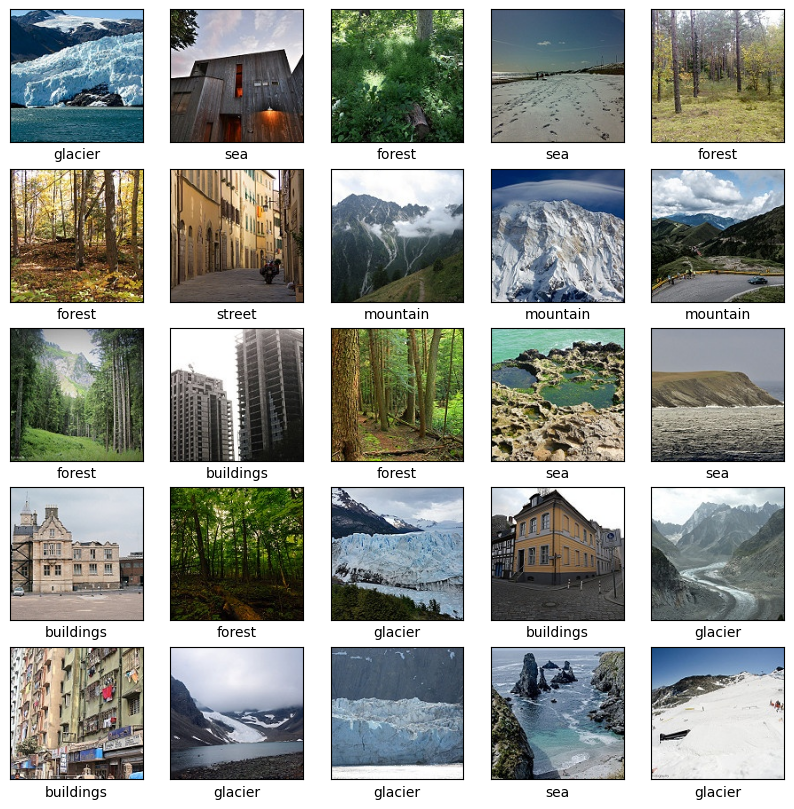

In [10]:
label_to_index = {label: index for index, label in enumerate(class_names)}

# Select 25 random image indices
random_indices = np.random.choice(len(train_images), size=25, replace=False)

plt.figure(figsize=(10,10))
for idx, random_index in enumerate(random_indices):
    plt.subplot(5,5,idx+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[random_index])  # Use the random_index here
    label_index = label_to_index[train_labels[random_index]]  # And here
    plt.xlabel(class_names[label_index])
plt.show()

Using pre trained model

In [11]:
# Import the VGG16 model from TensorFlow's Keras applications module.
# VGG16 is a deep convolutional neural network architecture known for its performance on the ImageNet visual recognition challenge.
from tensorflow.keras.applications import VGG16

In [12]:
# Load the VGG16 model pre-trained weights on ImageNet dataset.
# include_top=False omits the fully connected layers at the top of the network, making it suitable for feature extraction.
# input_shape=(128, 128, 3) sets the shape of the input images the network expects. Here, it's 128x128 pixels with 3 color channels (RGB).
VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

In [13]:
# Iterate through each layer in the base model.
for layer in VGG_model.layers:
    # Set the layer's trainable attribute to False.
    # This action freezes the weights and biases of the layer during training, meaning they won't be updated.
    # Freezing the pre-trained layers is important in transfer learning because we want to retain the knowledge the model has already learned from the ImageNet dataset.
    layer.trainable = False

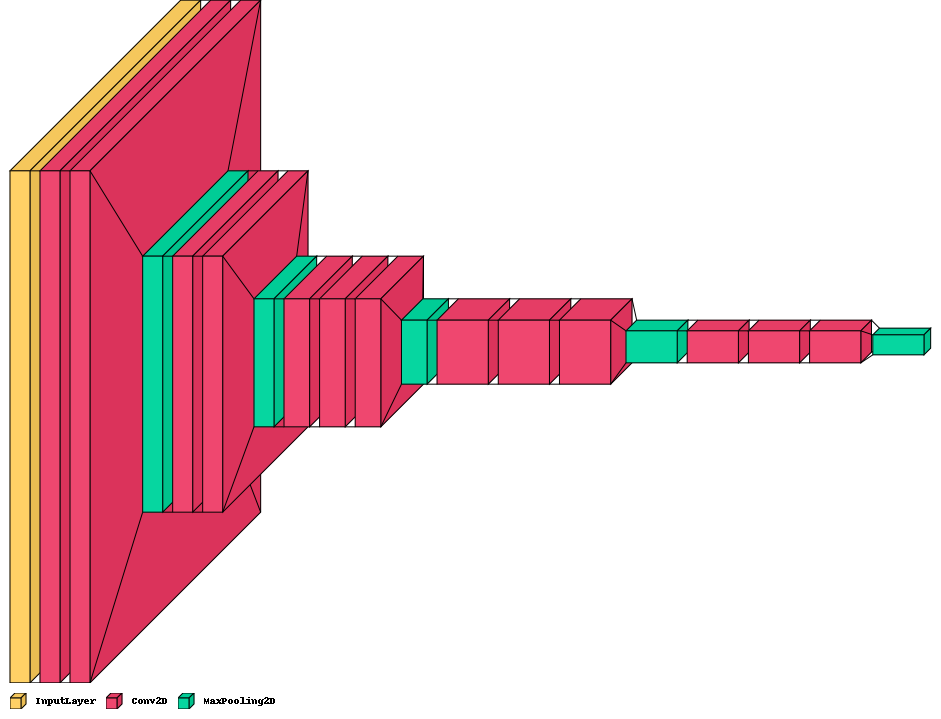

In [22]:
!pip install visualkeras
import visualkeras
# Let's visualize the model
visualkeras.layered_view(VGG_model,legend=True)


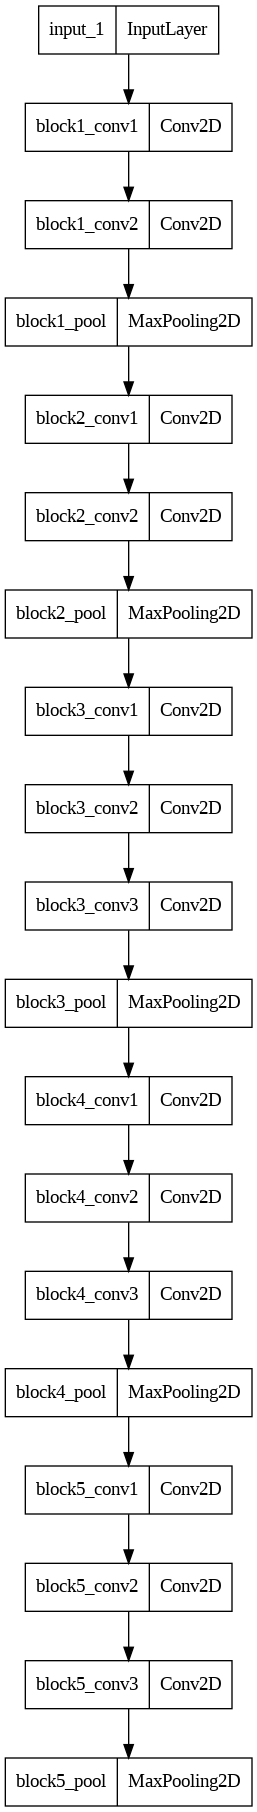

In [10]:
plot_model(VGG_model)

In [14]:
# `num_classes` will hold the total number of classes.
num_classes = len(class_names)

# Initialize a Sequential model.
model = models.Sequential()

# Add the pre-trained VGG16 model as the base of your model.
# This includes all the convolutional layers of VGG16, pre-trained on ImageNet.
model.add(VGG_model)

# Flatten the output of the VGG16 model because dense layers expect 1D inputs.
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu')) # Add a Dense (fully connected) layer to interpret the features extracted by VGG16.
# 256 neurons are used here, but this number can be adjusted depending on your dataset's complexity.
model.add(layers.Dropout(0.5)) # Add a Dropout layer to prevent overfitting
# Final Dense layer for classification. The number of neurons equals the number of classes,
# with a softmax activation function to output probabilities for each class.
model.add(layers.Dense(num_classes, activation='softmax'))

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 6)                 1542      
                                                                 
Total params: 16813638 (64.14 MB)
Trainable params: 2098950 (8.01 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


Compile and train the model

In [ ]:
model.compile(optimizer='sgd',
              loss=tf.keras.losses.SparseCategoricalCrossentropy()) #,
              #metrics=['accuracy'])

history = model.fit(train_images, train_labels_encoded , epochs=15,
                    validation_data=(test_images, test_labels_encoded))

Evaluate the model

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels_encoded, verbose=2)

In [ ]:
print(test_acc)

In [ ]:
# First, get predictions for validation images
predicted_scores = model.predict(test_images)  # Note: We are using test_images as you named your validation set 'test'
predicted_labels = np.argmax(predicted_scores, axis=1)

# Convert numerical labels back to class names
index_to_label = {index: label for label, index in label_to_index.items()}

# Select 25 random image indices from the validation set
random_indices = np.random.choice(len(test_images), size=25, replace=False)

plt.figure(figsize=(15,15))
for idx, random_index in enumerate(random_indices):
    plt.subplot(5,5,idx+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[random_index])
    predicted_label = index_to_label[predicted_labels[random_index]]
    true_label = test_labels[random_index]
    if predicted_label == true_label:
        color = 'green'
    else:
        color = 'red'
    plt.xlabel(f"{predicted_label} ({true_label})", color=color)  # Plotting predicted label (true label)
plt.show()

In [ ]:
test_labels

In [ ]:
# Convert numerical labels back to class names
# Convert numerical labels back to class names
predicted_labels = [index_to_label[index] for index in predicted_labels]

In [ ]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(test_labels, predicted_labels)

# Plot the confusion matrix using a heatmap.
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis',
            xticklabels=[index_to_label[i] for i in range(len(index_to_label))],
            yticklabels=[index_to_label[i] for i in range(len(index_to_label))])
plt.title('Confusion Matrix for Model')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()